In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('wx_user.csv')

In [3]:
df.head()

,user_id,follow_time,auth_time,createtime,order_no,paid_cash,create_date
0,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018/12/29
1,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.021012e+14,50.0,2021/1/15
2,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018110e+14,1.0,2018/11/2
3,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018122e+14,1.0,2018/12/23
4,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018121e+14,1.0,2018/12/7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738066 entries, 0 to 738065
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      738066 non-null  int64  
 1   follow_time  738066 non-null  object 
 2   auth_time    730518 non-null  object 
 3   createtime   738066 non-null  object 
 4   order_no     700123 non-null  float64
 5   paid_cash    700123 non-null  float64
 6   create_date  700123 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 39.4+ MB


In [5]:
df.drop_duplicates(subset='order_no', inplace=True)
df.describe()

,user_id,order_no,paid_cash
count,700124.000000,7.001230e+05,700123.000000
mean,192485.010128,2.020049e+14,957.785317
std,186695.609254,1.762840e+11,3498.456584
min,2.000000,2.016052e+14,0.010000
25%,39286.000000,2.019023e+14,12.000000
50%,115615.000000,2.020111e+14,40.000000
75%,329243.000000,2.021102e+14,300.000000
max,761984.000000,2.023092e+14,460000.000000


In [6]:
df.isna().sum()

user_id          0
follow_time      0
auth_time      148
createtime       0
order_no         1
paid_cash        1
create_date      1
dtype: int64

In [7]:
# 按年聚合查看每年新增的好友数量及好友的注册年份分布
# 将'follow_time' 'auth_time'和转变成 datetime
df['auth_time']  = pd.to_datetime(df['auth_time'], format='%Y/%m/%d')
df['follow_time'] = pd.to_datetime(df['follow_time'], format='%Y/%m/%d')

#提取年份并创建新列
df['auth_year'] = df['auth_time'].dt.year
df['follow_year'] = df['follow_time'].dt.year

# 按'follow_time' 和 'auth_time'列分组，并对user_id进行去重统计
user_count_per_year = df.groupby(['auth_year', 'follow_year'])['user_id'].nunique().reset_index()

print(user_count_per_year)

    auth_year  follow_year  user_id
0      2014.0         2020       95
1      2014.0         2021      259
2      2014.0         2022      268
3      2014.0         2023       69
4      2015.0         2020      538
5      2015.0         2021     1630
6      2015.0         2022     1614
7      2015.0         2023      397
8      2016.0         2019        1
9      2016.0         2020      676
10     2016.0         2021     2305
11     2016.0         2022     2495
12     2016.0         2023      597
13     2017.0         2019        1
14     2017.0         2020      934
15     2017.0         2021     3545
16     2017.0         2022     3537
17     2017.0         2023      909
18     2018.0         2019        1
19     2018.0         2020     1213
20     2018.0         2021     5111
21     2018.0         2022     4743
22     2018.0         2023     1510
23     2019.0         2019        1
24     2019.0         2020     1210
25     2019.0         2021     6613
26     2019.0         2022  

In [8]:
# 使用pivot_table 将数据转换为二维数组
pivot_table = user_count_per_year.pivot(index='auth_year', columns='follow_year', values='user_id').fillna(0).astype(np.int64)

print(pivot_table)

follow_year  2019  2020  2021  2022  2023
auth_year                                
2014.0          0    95   259   268    69
2015.0          0   538  1630  1614   397
2016.0          1   676  2305  2495   597
2017.0          1   934  3545  3537   909
2018.0          1  1213  5111  4743  1510
2019.0          1  1210  6613  5994  1792
2020.0          0   865  5052  4624  1251
2021.0          0    25  3821  3651  1135
2022.0          0    12    53  1997  1140
2023.0          0     3     7    40   917


In [9]:
# 将建单时间转化为 datetime
df['create_date'] = pd.to_datetime(df['create_date'], format='%Y/%m/%d')
df['create_year'] = df['create_date'].dt.year

# 按年聚合
cash_per_create_year = df.groupby(['create_year'])['paid_cash'].sum()


print(cash_per_create_year)

create_year
2016.0    3.598671e+06
2017.0    2.194627e+07
2018.0    4.104005e+07
2019.0    1.559391e+08
2020.0    1.540240e+08
2021.0    1.496043e+08
2022.0    9.640025e+07
2023.0    4.801485e+07
Name: paid_cash, dtype: float64


In [10]:
#合并学习用户数据
#读取学习用户数据
df_study = pd.read_csv('customer_learning.csv')
#通过user_id进行合并
merged_dataframe = pd.merge(df, df_study, on='user_id', how='inner')
merged_dataframe.head()

,user_id,follow_time,auth_time,createtime,order_no,paid_cash,create_date,auth_year,follow_year,create_year,action_month,watch_minute,course,broadcast,playback
0,2,2023-03-09 14:36:14,2014-08-03 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018-12-29,2014.0,2023,2018.0,2021-01,15.17,0,14.17,1
1,2,2023-03-09 14:36:14,2014-08-03 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018-12-29,2014.0,2023,2018.0,2021-02,11.13,0,11.13,0
2,2,2023-03-09 14:36:14,2014-08-03 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018-12-29,2014.0,2023,2018.0,2021-03,20.00,0,20.00,0
3,2,2023-03-09 14:36:14,2014-08-03 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018-12-29,2014.0,2023,2018.0,2021-04,96.28,1,95.28,0
4,2,2023-03-09 14:36:14,2014-08-03 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018-12-29,2014.0,2023,2018.0,2021-05,1.00,0,0.00,1


In [11]:
# 删除重复的订单数据
merged_dataframe.drop_duplicates(subset='order_no', inplace=True)

In [12]:
merged_dataframe['user_id'].nunique() 

64588

In [13]:
merged_dataframe.head()

,user_id,follow_time,auth_time,createtime,order_no,paid_cash,create_date,auth_year,follow_year,create_year,action_month,watch_minute,course,broadcast,playback
0,2,2023-03-09 14:36:14,2014-08-03 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018-12-29,2014.0,2023,2018.0,2021-01,15.17,0,14.17,1
32,2,2023-03-09 14:36:14,2014-08-03 22:39:25,2014/4/30 09:30:23,2.021012e+14,50.0,2021-01-15,2014.0,2023,2021.0,2021-01,15.17,0,14.17,1
64,2,2023-03-09 14:36:14,2014-08-03 22:39:25,2014/4/30 09:30:23,2.018110e+14,1.0,2018-11-02,2014.0,2023,2018.0,2021-01,15.17,0,14.17,1
96,2,2023-03-09 14:36:14,2014-08-03 22:39:25,2014/4/30 09:30:23,2.018122e+14,1.0,2018-12-23,2014.0,2023,2018.0,2021-01,15.17,0,14.17,1
128,2,2023-03-09 14:36:14,2014-08-03 22:39:25,2014/4/30 09:30:23,2.018121e+14,1.0,2018-12-07,2014.0,2023,2018.0,2021-01,15.17,0,14.17,1


In [14]:
#筛选30分+用户作为统计对象
#筛选99+订单作为金额及消费频次统计对象
merged_dataframe = merged_dataframe[(merged_dataframe['watch_minute'] >= 30) & (merged_dataframe['paid_cash'] >= 99)]
merged_dataframe['user_id'].nunique()

20500

In [15]:
df_rfmt = summary_data_from_transaction_data(merged_dataframe,
                                             'user_id',
                                             'create_date',
                                             'paid_cash',
                                             observation_period_end='2023-10-1')

df_rfmt.head()

,frequency,recency,T,monetary_value
user_id,,,,
67,1.0,48.0,1807.0,300.000000
83,2.0,2190.0,2350.0,399.500000
112,3.0,2195.0,2408.0,233.000000
119,9.0,2134.0,2413.0,12108.222222
123,5.0,2212.0,2356.0,227.540000


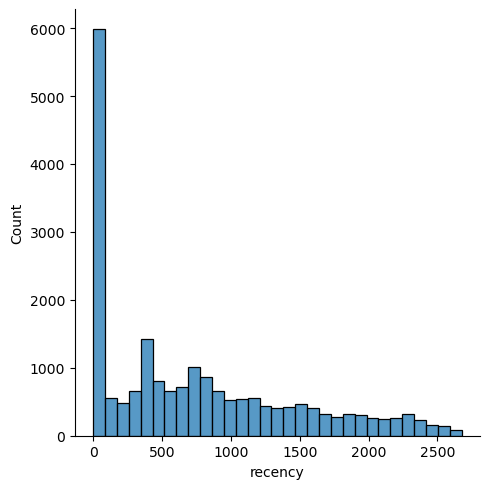

In [16]:
ax = sns.displot(df_rfmt['recency'])

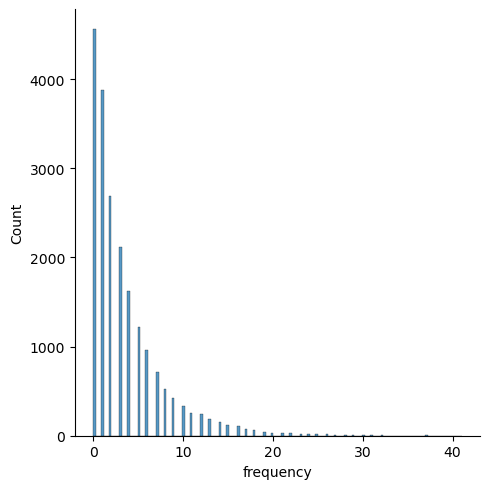

In [17]:
ax = sns.displot(df_rfmt['frequency'])
plt.show()

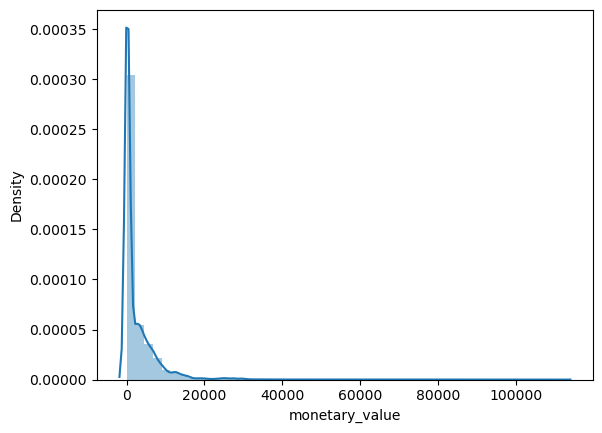

In [18]:
ax = sns.distplot(df_rfmt['monetary_value'])
plt.show()

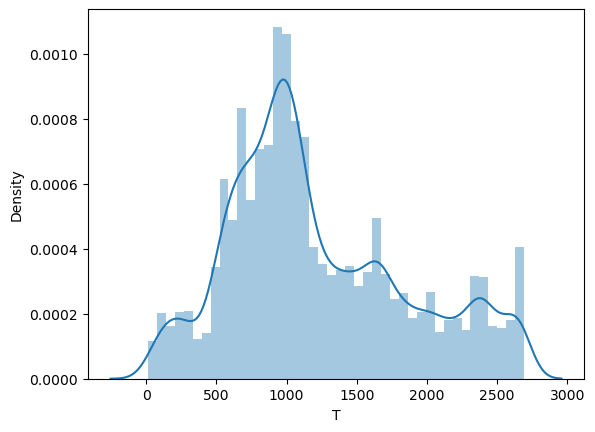

In [19]:
ax = sns.distplot(df_rfmt['T'])
plt.show()

In [20]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(df_rfmt['frequency'], df_rfmt['recency'], df_rfmt['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.236614,0.018265,1.200816,1.272413
alpha,368.208769,6.858694,354.765729,381.651809
a,0.118671,0.004855,0.109155,0.128187
b,0.959252,0.032138,0.896261,1.022243


<Figure size 1200x1200 with 0 Axes>

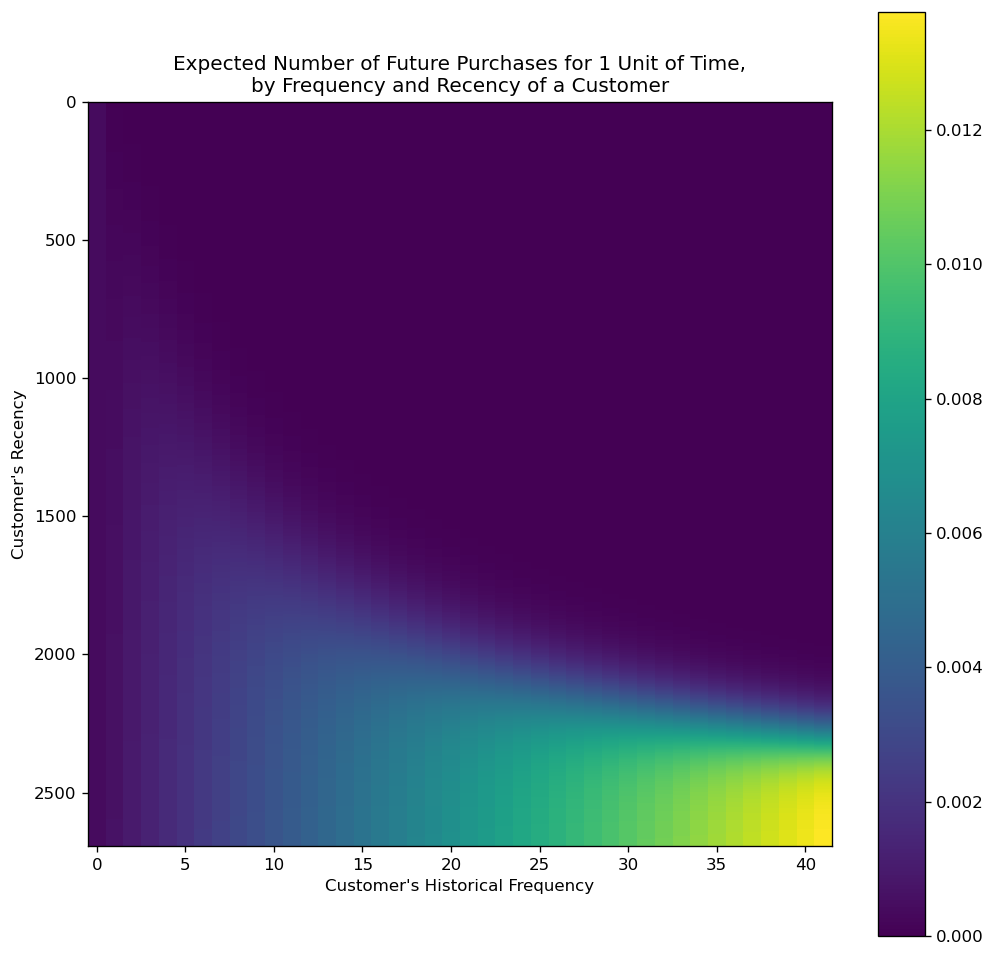

In [22]:
figure(num=None, figsize=(10, 10), dpi=120, facecolor='w', edgecolor='k' )
plot_frequency_recency_matrix(bgf)
plt.show()

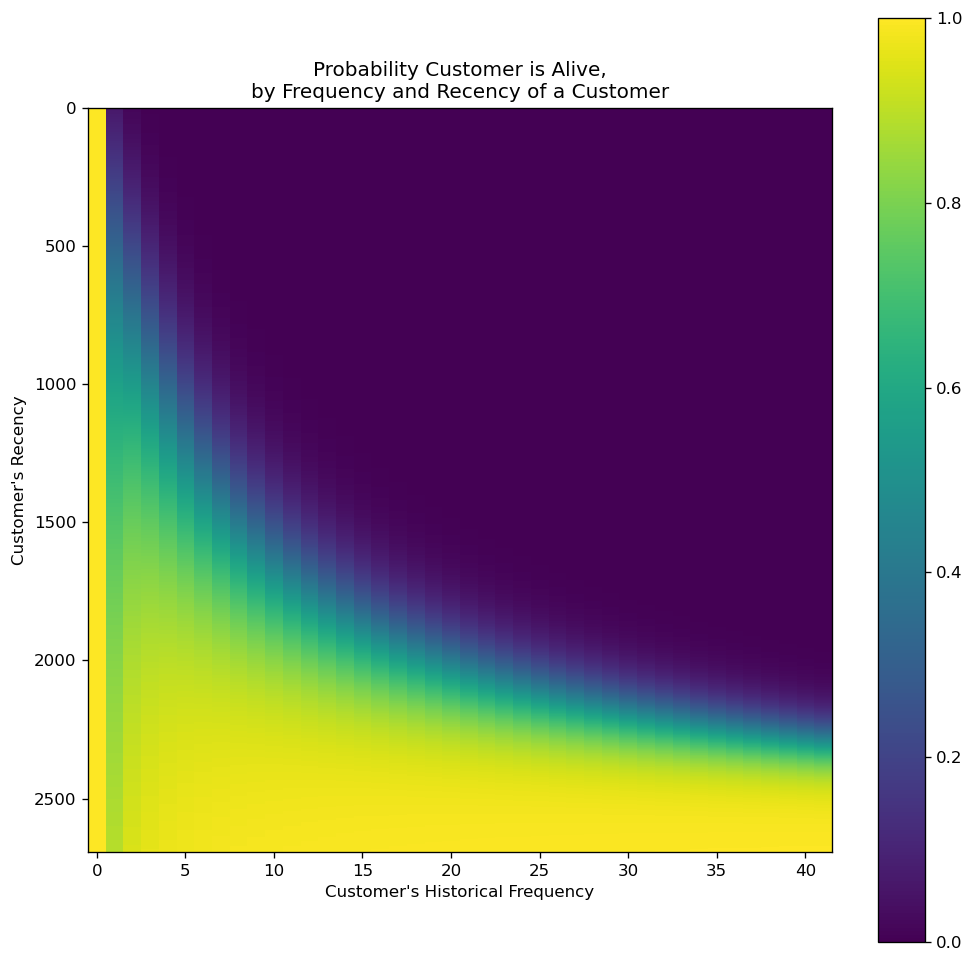

In [23]:
figure(num=None, figsize=(10, 10), dpi=120, facecolor='w', edgecolor='k' )
plot_probability_alive_matrix(bgf)
plt.show()

In [24]:
# 预测用户未来产生的订单数量

t = 180
df_rfmt['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                      df_rfmt['frequency'],
                                                                                      df_rfmt['recency'],
                                                                                      df_rfmt['T'])
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases
user_id,,,,,
67,1.0,48.0,1807.0,300.000000,0.030635
83,2.0,2190.0,2350.0,399.500000,0.198568
112,3.0,2195.0,2408.0,233.000000,0.258814
119,9.0,2134.0,2413.0,12108.222222,0.634933
123,5.0,2212.0,2356.0,227.540000,0.396883
...,...,...,...,...,...
759699,2.0,11.0,34.0,8630.000000,1.308494
760350,2.0,14.0,30.0,800.000000,1.326378
760404,1.0,18.0,30.0,25600.000000,0.862110


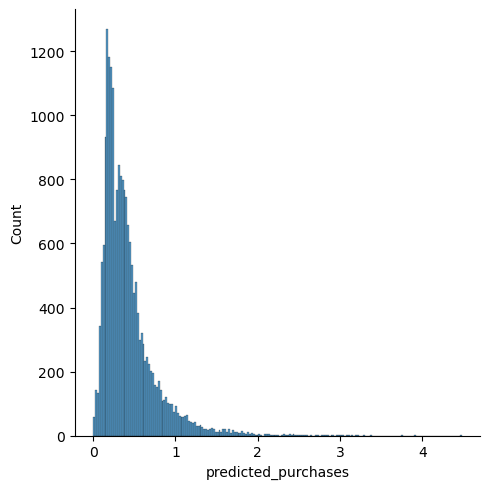

In [25]:
#图形化预测结果分布
ax = sns.displot(df_rfmt['predicted_purchases'])
plt.show()

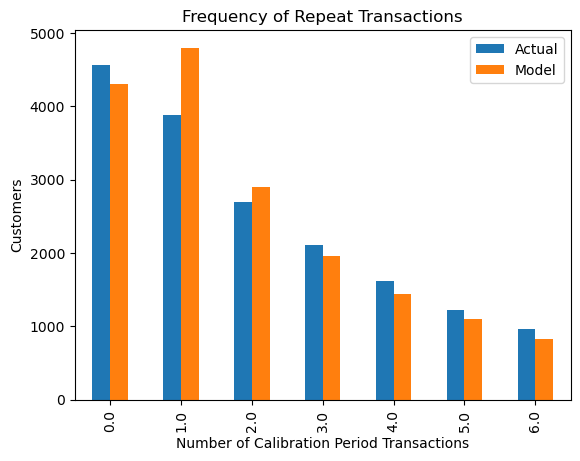

In [26]:
plot_period_transactions(bgf)
plt.show()

In [27]:
#观察周期3年，时间越长有利于模型预测的准确性
summary_cal_holdout = calibration_and_holdout_data(merged_dataframe, 
                                                   'user_id', 
                                                   'create_date',
                                                    calibration_period_end='2020-10-01',
                                                    observation_period_end='2023-10-01')

In [28]:
summary_cal_holdout.sort_values(by='frequency_holdout', ascending=False).head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
user_id,,,,,
160849,7.0,576.0,589.0,31.0,1095.0
35637,7.0,991.0,1233.0,30.0,1095.0
107508,6.0,994.0,1058.0,28.0,1095.0
424627,0.0,0.0,279.0,28.0,1095.0
26854,11.0,1451.0,1478.0,28.0,1095.0


In [29]:
bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 9592 subjects, a: 0.00, alpha: 527.97, b: 0.00, r: 1.57>

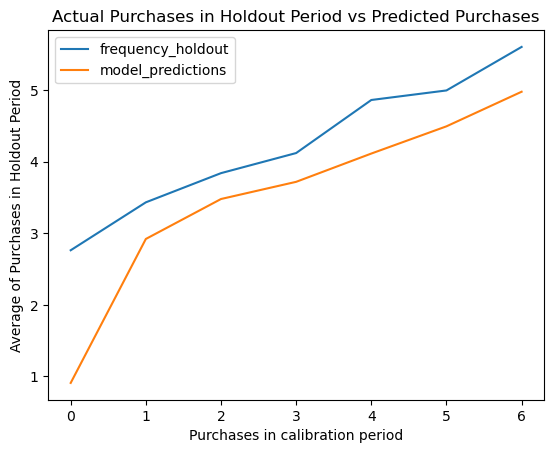

In [30]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
plt.show()

In [31]:
# Predicting customer lifetime value ，using Gamma-Gamma model
#筛选留存的用户
returning_customers = df_rfmt[ (df_rfmt['frequency'] > 0) & (df_rfmt['monetary_value'] > 0)]
returning_customers.sort_values(by='monetary_value', ascending=False).head()

,frequency,recency,T,monetary_value,predicted_purchases
user_id,,,,,
102589,37.0,1447.0,2082.0,112212.663784,0.009063
425461,1.0,1.0,1251.0,60600.000000,0.056266
338589,1.0,69.0,1276.0,55200.000000,0.071458
198816,1.0,10.0,1567.0,53600.000000,0.035783
278118,1.0,1.0,1251.0,50000.000000,0.056266


In [32]:
#检查Monetary和Frequency的相关性

returning_customers[['monetary_value', 'frequency']].corr()


,monetary_value,frequency
monetary_value,1.000000,-0.002903
frequency,-0.002903,1.000000


In [33]:
# -0.00290 分数说明相关度符合Gamma-Gamma模型（即，用户产生的消费金额和频次是独立的
# Fit the Gamma-Gamma Model
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 15940 subjects, p: 2.44, q: 0.63, v: 105.29>

In [34]:
# 使用模型预测订单的平均客单价（金额）
predicted_monetary = ggf.conditional_expected_average_profit(
        returning_customers['frequency'],
        returning_customers['monetary_value']
)

In [35]:
# 将返回的结果展示出来，并按照从大到小顺序进行展示
aov_df = pd.DataFrame(predicted_monetary,columns = ['aov'])
aov_df = aov_df.sort_values(by='aov', ascending=False)
aov_df.head()

,aov
user_id,
102589,112675.119841
425461,71495.859235
338589,65135.990667
198816,63251.585165
278118,59011.672786


In [36]:
# 查看最小的后5个数据
aov_df.tail(5)

,aov
user_id,
104591,128.103338
280772,123.793926
464109,123.793926
540636,123.793926
303675,123.793926


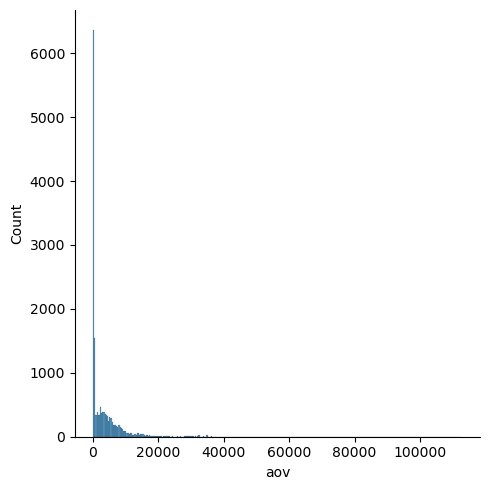

In [37]:
# 查看分布图
ax = sns.displot(aov_df['aov'])
plt.show()

In [38]:
# 预测用户的CLV：
# 使用BG/NBD 模型预测未来产生的订单数

bgf.fit(returning_customers['frequency'], 
        returning_customers['recency'], 
        returning_customers['T'])

<lifetimes.BetaGeoFitter: fitted with 15940 subjects, a: 0.17, alpha: 462.17, b: 1.09, r: 1.99>

In [39]:
#预测用户的CLV
#结合Gamma-Gamma模型预测的客单价进行计算CLV,同时现金流的月折现率按照 0.01进行计算

preds = ggf.customer_lifetime_value(
    bgf,
    returning_customers['frequency'],
    returning_customers['recency'],
    returning_customers['T'],
    returning_customers['monetary_value'],
    time = 12,
    discount_rate = 0.01
)

preds = preds.to_frame().reset_index()

preds.sort_values(by='clv', ascending=False).head() 

,user_id,clv
5479,125912,62606.520622
15939,760849,53550.690445
15938,760815,51180.633775
14953,585633,50227.787729
15937,760404,49254.248011


In [40]:
# 检查一下尾部的值
preds.sort_values(by='clv', ascending=False).tail()

,user_id,clv
5450,125018,3.467688
4059,86404,3.347327
6588,157823,3.086482
7300,187028,2.308636
3131,57151,1.842816


In [41]:
#计算用户产生的总金额
preds['clv'].sum()

45754670.57108539